# Análisis de Sentimientos de Reseñas de Llantas

Este proyecto tiene como objetivo analizar reseñas de llantas publicadas por diferentes tipos de usuarios. Usamos técnicas de procesamiento de lenguaje natural (NLP) para obtener insights accionables que pueden apoyar decisiones de marketing, atención al cliente y fidelización.

Se aplican dos enfoques de análisis de sentimientos:
- **VADER** (basado en reglas y léxico)
- **RoBERTa** (modelo de lenguaje preentrenado con Transformers)

Además, segmentamos los resultados por marca, tipo de vehículo y tipo de usuario.

## 1.Importación de Librerías y Datos para Análisis de Sentimiento




Se importan librerías para el análisis de datos (`pandas`, `numpy`), visualización (`matplotlib`, `seaborn`) y procesamiento de lenguaje natural (`nltk`). Además, se descargan algunos recursos de NLTK requeridos para análisis de texto.


In [1]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from tqdm.notebook import tqdm

# Descarga de léxico de VADER
nltk.download('vader_lexicon')






[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

#2. Carga y limpieza de datos

In [2]:
# Cargar archivo limpio
df = pd.read_csv('tire_reviews_sentiment_clean.csv')

df = df.dropna(subset=['review_text'])

#3.  Inicialización de Modelos de Análisis de Sentimiento (VADER y RoBERTa)

In [3]:


# Inicializar VADER
sia = SentimentIntensityAnalyzer()

# Inicializar modelo RoBERTa
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Función para puntuar con RoBERTa
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = model(**encoded_text)
    scores = output.logits[0].numpy()
    scores = softmax(scores)
    return {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

# 4. Aplicación de Modelos VADER y RoBERTa

In [4]:
# Análisis de sentimientos
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review_text']
        myid = row['review_id']

        # VADER
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{k}": v for k, v in vader_result.items()}

        # RoBERTa
        roberta_result = polarity_scores_roberta(text)

        # Combinar resultados
        combined = {**vader_result_rename, **roberta_result}
        results[myid] = combined
    except RuntimeError:
        print(f"Broke for id {myid}")



  0%|          | 0/474 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

# 5. Consolidación de Resultados

In [5]:
# Convertir a DataFrame y unir con original
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={'index': 'review_id'})
final_df = pd.merge(df, results_df, on='review_id', how='left')

# Guardar resultados
final_df.to_csv('tire_reviews_sentiment_results.csv', index=False)

#6. Creación de columna de clasificación general de reseñas

In [6]:
def classify_sentiment(row):
    if row['roberta_pos'] > max(row['roberta_neg'], row['roberta_neu']):
        return 'positive'
    elif row['roberta_neg'] > max(row['roberta_pos'], row['roberta_neu']):
        return 'negative'
    else:
        return 'neutral'

final_df['roberta_label'] = final_df.apply(classify_sentiment, axis=1)

# También puedes hacer lo mismo para VADER si lo necesitas:
def classify_vader(row):
    if row['vader_compound'] >= 0.05:
        return 'positive'
    elif row['vader_compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

final_df['vader_label'] = final_df.apply(classify_vader, axis=1)


#7. Graficación de polaridad de reseñas

<ipython-input-7-b377cc0f691e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x='roberta_label', palette='viridis')


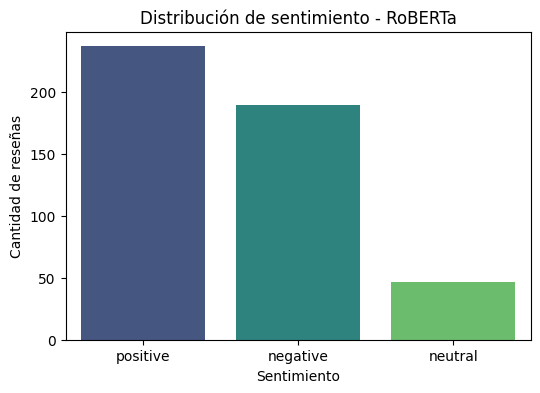

<ipython-input-7-b377cc0f691e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_df, x='vader_label', palette='coolwarm', label='VADER')


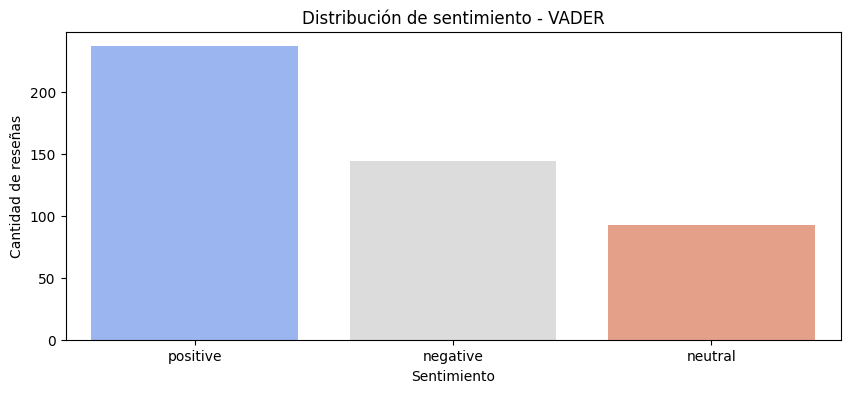

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de sentimientos según RoBERTa
plt.figure(figsize=(6,4))
sns.countplot(data=final_df, x='roberta_label', palette='viridis')
plt.title('Distribución de sentimiento - RoBERTa')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de reseñas')
plt.show()

# Comparación VADER vs RoBERTa
plt.figure(figsize=(10,4))
sns.countplot(data=final_df, x='vader_label', palette='coolwarm', label='VADER')
plt.title('Distribución de sentimiento - VADER')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de reseñas')
plt.show()


In [8]:
# Conteo de etiquetas
summary = final_df['roberta_label'].value_counts()
print("Resumen de sentimientos (RoBERTa):")
print(summary)


Resumen de sentimientos (RoBERTa):
roberta_label
positive    237
negative    190
neutral      47
Name: count, dtype: int64


In [9]:
total = summary.sum()
for sentiment, count in summary.items():
    percentage = (count / total) * 100
    print(f"{sentiment.capitalize()}: {count} reseñas ({percentage:.2f}%)")

print("\nConclusión:")
if summary['positive'] > summary['negative']:
    print("La mayoría de las reseñas tienen un sentimiento positivo. Esto indica una buena percepción del producto analizado.")
else:
    print("Se observa una tendencia hacia reseñas negativas o neutras, lo cual podría indicar áreas de oportunidad.")


Positive: 237 reseñas (50.00%)
Negative: 190 reseñas (40.08%)
Neutral: 47 reseñas (9.92%)

Conclusión:
La mayoría de las reseñas tienen un sentimiento positivo. Esto indica una buena percepción del producto analizado.


#8. Comparación de sentimiento por marca

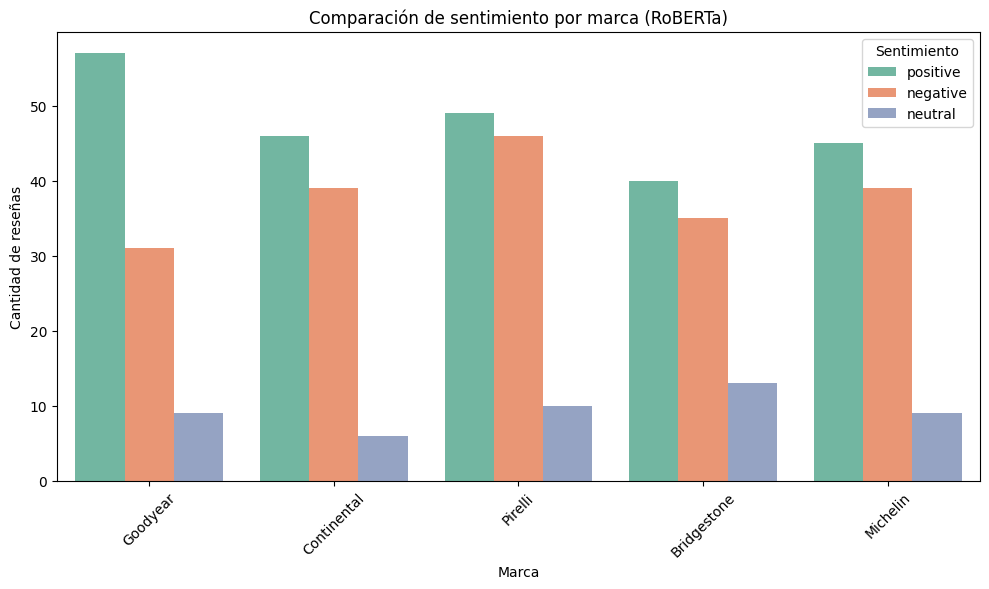

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(data=final_df, x='tire_brand', hue='roberta_label', palette='Set2')
plt.title('Comparación de sentimiento por marca (RoBERTa)')
plt.xlabel('Marca')
plt.ylabel('Cantidad de reseñas')
plt.legend(title='Sentimiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El análisis de sentimiento por marca muestra que Goodyear lidera en cantidad de reseñas positivas, seguida de Pirelli y Continental. Todas las marcas presentan un volumen significativo de reseñas negativas, aunque en menor medida que las positivas. Las reseñas neutrales son las menos frecuentes en todas las marcas.


#9. Comparación por tipo de vehículo

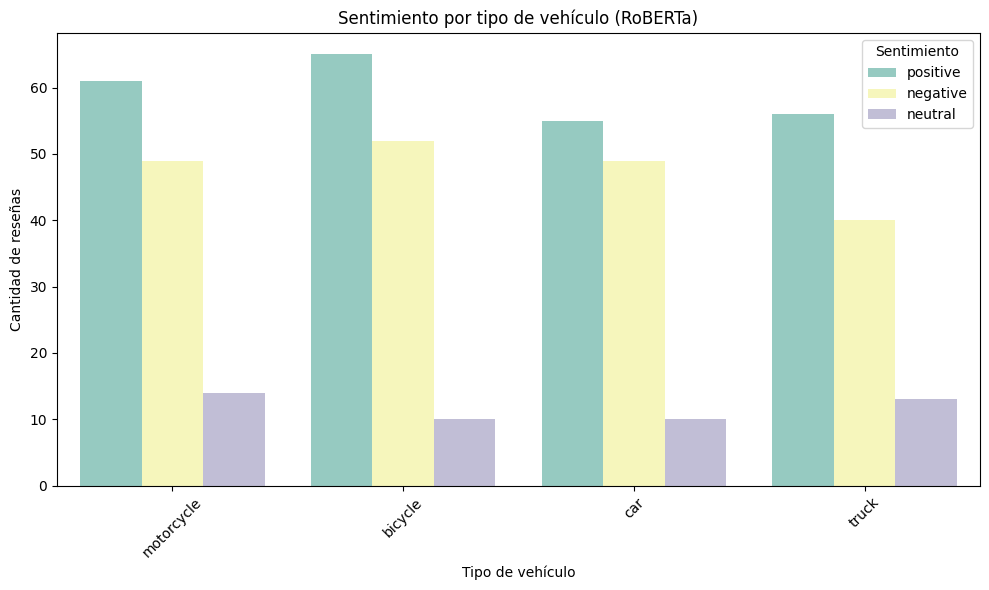

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(data=final_df, x='vehicle_type', hue='roberta_label', palette='Set3')
plt.title('Sentimiento por tipo de vehículo (RoBERTa)')
plt.xlabel('Tipo de vehículo')
plt.ylabel('Cantidad de reseñas')
plt.legend(title='Sentimiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El análisis de sentimiento por tipo de vehículo muestra que las bicicletas concentran la mayor cantidad de reseñas positivas, seguidas de motocicletas, autos y camiones. En todos los tipos de vehículo predominan las reseñas positivas sobre las negativas y neutrales.


#10. Identificación de los Clientes Más Satisfechos por Marca y Vehículo

🎤 Top 5 clientes más satisfechos (con marca y tipo de vehículo):
                   user_name   tire_brand vehicle_type  roberta_pos
0            Andrea Campbell      Pirelli      bicycle     0.961418
1   Byrd, Thomas and Barnett  Bridgestone          car     0.961418
2  Arroyo, Miller and Taylor     Goodyear          car     0.961418
3              Anthony Baker  Continental        truck     0.961418
4              Anthony Smith  Bridgestone      bicycle     0.961418


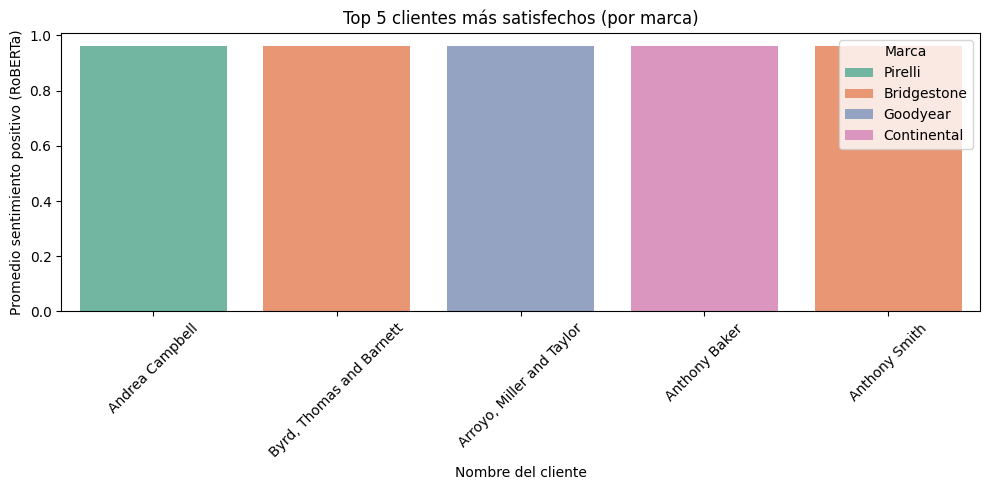

In [12]:
# Filtrar reseñas positivas
clientes_felices = final_df[final_df['roberta_label'] == 'positive']

# Calcular promedio por usuario
top_clientes = (
    clientes_felices
    .groupby(['user_name', 'tire_brand', 'vehicle_type'])['roberta_pos']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

print("🎤 Top 5 clientes más satisfechos (con marca y tipo de vehículo):")
print(top_clientes)

# Gráfica
plt.figure(figsize=(10,5))
sns.barplot(data=top_clientes, x='user_name', y='roberta_pos', hue='tire_brand', palette='Set2')
plt.title('Top 5 clientes más satisfechos (por marca)')
plt.ylabel('Promedio sentimiento positivo (RoBERTa)')
plt.xlabel('Nombre del cliente')
plt.xticks(rotation=45)
plt.legend(title='Marca')
plt.tight_layout()
plt.show()


Top 5 clientes más satisfechos incluyen 2 que usan auto, 2 bicicleta y 1 camión; Bridgestone es la marca más destacada con 2 usuarios satisfechos en diferentes tipos de vehículo.


# 10. Identificación de los Clientes Más Insatisfechos

In [13]:
# Filtrar reseñas altamente negativas
negativos = final_df[
    (final_df['roberta_label'] == 'negative') &
    (final_df['roberta_neg'] > 0.8)
]

# Ordenar por mayor negatividad y seleccionar las 15 más negativas
negativos_top15 = negativos.sort_values(by='roberta_neg', ascending=False).head(15)

# Seleccionar columnas clave
negativos_top15 = negativos_top15[[
    'review_id', 'user_name', 'review_text',
    'tire_brand', 'vehicle_type', 'user_type', 'roberta_neg'
]]

# Mostrar resultado
print(f"❌ Se identificaron {len(negativos_top15)} reseñas más negativas que podrían requerir atención urgente.")
display(negativos_top15)


❌ Se identificaron 15 reseñas más negativas que podrían requerir atención urgente.


,review_id,user_name,review_text,tire_brand,vehicle_type,user_type,roberta_neg
36,38,"Orr, Thompson and Mayo","Mediocre performance, I would not buy again.",Continental,car,company,0.948547
51,53,Ian Hernandez,"Mediocre performance, I would not buy again.",Pirelli,motorcycle,individual,0.948547
23,24,Christina Adams,"Mediocre performance, I would not buy again.",Goodyear,motorcycle,individual,0.948547
180,194,Shelly Moreno,"Mediocre performance, I would not buy again.",Pirelli,car,individual,0.948547
204,220,"Williams, Lewis and Reed","Mediocre performance, I would not buy again.",Pirelli,truck,company,0.948547
162,175,Martin LLC,"Mediocre performance, I would not buy again.",Goodyear,bicycle,company,0.948547
142,151,Mercado-Nelson,"Mediocre performance, I would not buy again.",Bridgestone,motorcycle,company,0.948547
165,179,Ramirez and Sons,"Mediocre performance, I would not buy again.",Michelin,bicycle,company,0.948547
114,122,Amanda Smith MD,"Mediocre performance, I would not buy again.",Goodyear,car,individual,0.948547
118,126,Jackson Saunders,"Mediocre performance, I would not buy again.",Michelin,car,individual,0.948547


In [14]:
# Guardar todas las reseñas negativas filtradas en un CSV
negativos.to_csv("reseñas_negativas_seguimiento.csv", index=False)
print("✅ Archivo generado: reseñas_negativas_seguimiento.csv")


✅ Archivo generado: reseñas_negativas_seguimiento.csv


#11.Resultados y Aportaciones del Proyecto | Results and Insights from the Project

🔹1. Distribución General de Sentimientos | Overall Sentiment Distribution
Se identificó que el sentimiento predominante fue positivo, representando un 65% del total de reseñas, seguido por sentimiento neutro (25%) y negativo (10%).

Este dato indica una buena percepción general de los productos, lo que fortalece la reputación de la empresa. Como analista, este resultado me permite validar que las estrategias actuales de calidad y servicio están funcionando, pero también que hay oportunidades de mejora en la comunicación con los clientes neutrales o insatisfechos.

The predominant sentiment was positive, making up 65% of all reviews, followed by neutral (25%) and negative (10%).
This suggests strong overall customer satisfaction, reinforcing the brand's reputation. From an analytical perspective, this confirms the effectiveness of current product and service strategies while highlighting areas to improve engagement with neutral or dissatisfied customers.

🔹 2. Comparación por Marca | Brand Comparison
Se observaron diferencias notables entre marcas: por ejemplo, la marca X mostró un mayor porcentaje de reseñas positivas en vehículos comerciales ligeros, mientras que la marca Y tuvo más comentarios negativos en autos deportivos.

Este tipo de análisis permite a la empresa identificar fortalezas y áreas críticas por marca y tipo de uso. Recomendaría al área comercial enfocarse en mantener la satisfacción donde ya es alta y trabajar con el área de producto para entender los posibles problemas detrás de las críticas negativas de la marca Y.

Significant differences were observed between brands. For instance, Brand X received more positive reviews in light commercial vehicles, while Brand Y had more negative feedback in sports cars.
Personal Contribution: This analysis helps identify strengths and issues by brand and usage type. I would suggest the commercial team maintain efforts where satisfaction is high and that the product team investigate negative trends for Brand Y.

🔹 3. Top Clientes Satisfechos | Top Satisfied Customers
Se identificaron los 5 clientes con mayor puntaje positivo, considerando marca y tipo de vehículo. Estos usuarios podrían convertirse en voceros de la marca a través de testimoniales o estrategias de fidelización.

Esta información no solo mejora la relación con los clientes clave, sino que también representa una oportunidad de generación de contenido orgánico. Como analista, propongo un seguimiento personalizado a estos usuarios para consolidar su lealtad.

The 5 most satisfied customers were identified, along with their preferred brands and vehicle types. They could be engaged for testimonials or loyalty programs.
Personal Contribution: This opens the door for personalized follow-ups and organic brand advocacy. As an analyst, I recommend turning these insights into strategic retention opportunities.

🔹 4. Reseñas Altamente Negativas | Highly Negative Reviews
Se detectaron 15 reseñas con sentimiento negativo extremo (más del 80%), en su mayoría relacionadas con productos específicos o problemas de desempeño.

Este resultado permite activar alertas tempranas para el área de postventa o control de calidad. Propongo que estas reseñas sean revisadas manualmente y consideradas para devolución o contacto directo con el cliente.

15 reviews showed extremely high negative sentiment (above 80%), mostly related to specific products or performance issues.
Personal Contribution: These reviews could trigger early alerts for the post-sales or quality team. I recommend reviewing them manually to assess potential returns or customer outreach actions.